In [223]:
from dataclasses import replace

import numpy as np

from fit.matrices.const_mats import create_p2d_mat
from fit.matrices.top_mats import create_top_mats
from fit.mesh.box import Box, mesh_boxes
from fit.mesh.mesh import Mesh
from fit.plot.plot_field import plot_field
from fit.plot.plot_pot import plot_pot
from fit.solver.solve_poisson import solve_poisson

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [224]:
## Generate mesh
n = 50
nz = 5
xmesh = np.linspace(0, 1, n)
ymesh = np.linspace(0, 1, n)
zmesh = np.linspace(0, 1, nz)
msh = Mesh(xmesh, ymesh, zmesh)

In [225]:
## Mesh boxes
# Conductor
sig = 58e6      # Conductivity
lam = 401       # Thermal conductivity
n_width = 10    # Conductor width

box_sig_0 = Box(sig, (0, int(msh.nx / 2)), (int(msh.ny / 2 - n_width), int(msh.ny / 2 + n_width)), (0, msh.nz))
box_sig_1 = Box(sig, (int(msh.nx / 2), msh.nx), (int(msh.ny / 2 - n_width / 2), int(msh.ny / 2 + n_width / 2)), (0, msh.nz))
box_lam_0 = replace(box_sig_0, value=lam)
box_lam_1 = replace(box_sig_1, value=lam)

sig_arr = mesh_boxes(msh, [box_sig_0, box_sig_1], 0)
lam_arr = mesh_boxes(msh, [box_lam_0, box_lam_1], 0)
m_sig = create_p2d_mat(msh, sig_arr)
m_lam = create_p2d_mat(msh, lam_arr)

# Air
eps = 8.854e-12
m_eps = create_p2d_mat(msh, eps)

In [226]:
## Set boundary conditions
V0 = 0
V1 = 1

box_bc_0 = Box(V0, (0, 1), (0, msh.ny), (0, msh.nz))
box_bc_1 = Box(V1, (n - 1, n), (0, msh.ny), (0, msh.nz))
bc = mesh_boxes(msh, [box_bc_0, box_bc_1], np.nan)

In [227]:
## Current excitation TODO: Update
I0 = 1e7

g,_,_ = create_top_mats(msh)
i = np.zeros(3*msh.np)
# idx = [msh.idx(0, int(n/2 + i), np.arange(nz)) + 0*msh.np for i in np.linspace(-10, 10)]
# i[idx] = I0
q = -g.T @ i
# idx = [msh.idx(0, int(n/2 + i), np.arange(nz)) for i in np.linspace(-10, 10)]
# idx = msh.idx(int(n/2), int(n/2), np.arange(nz))
# q = np.zeros(msh.np)
# q[idx] = I0

In [228]:
## Solve system
phi = solve_poisson(msh, q, m_eps, bc)  # TODO: Use m_sig not m_eps

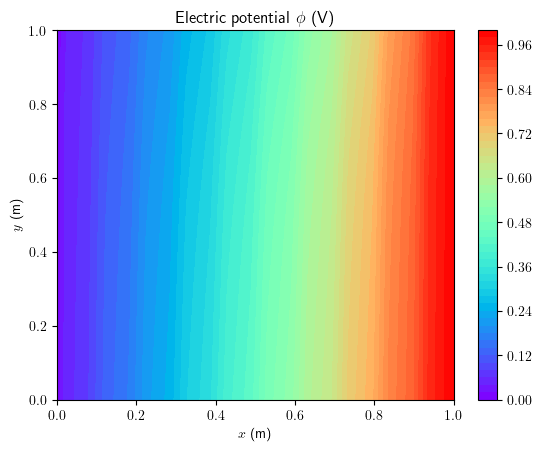

In [229]:
## Plot phi
plot_pot(msh, phi, nz=2, levels=n, cmap='rainbow', title='Electric potential $\phi$ (V)')

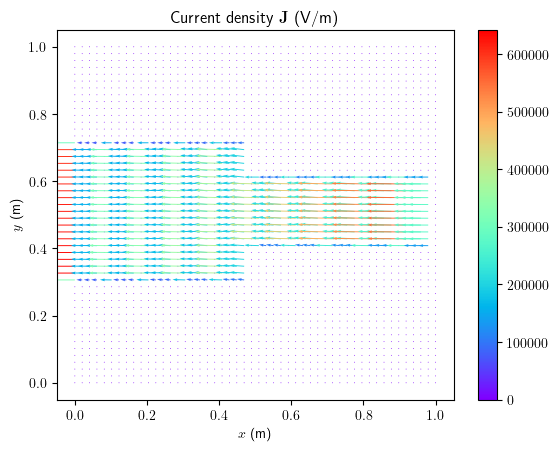

In [230]:
# Electrical field
e = -g @ phi
j = m_sig @ e
plot_field(msh, j, nz=2, cmap='rainbow', title=r'Current density $\mathbf{J}$ (V/m)')

In [231]:
## Power calculation
pe = e * j                          # Power on edge vector
pv = 0.5*np.abs(g.T) @ pe           # Power on dual volume vector

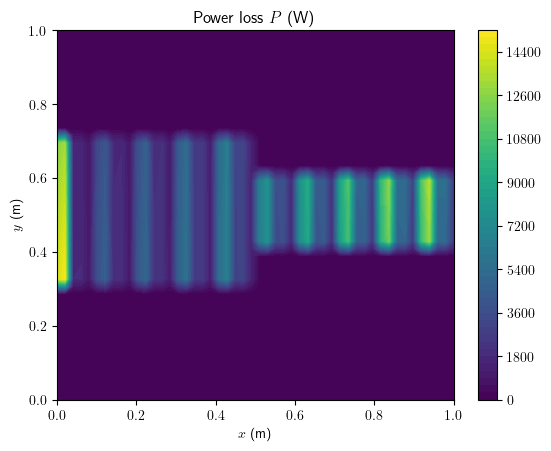

In [232]:
## Plot power
plot_pot(msh, pv, nz=2, levels=n, title='Power loss $P$ (W)')

In [233]:
## Solve thermal system
bc = np.full(msh.np, np.nan)
theta = solve_poisson(msh, pv, m_lam, bc)

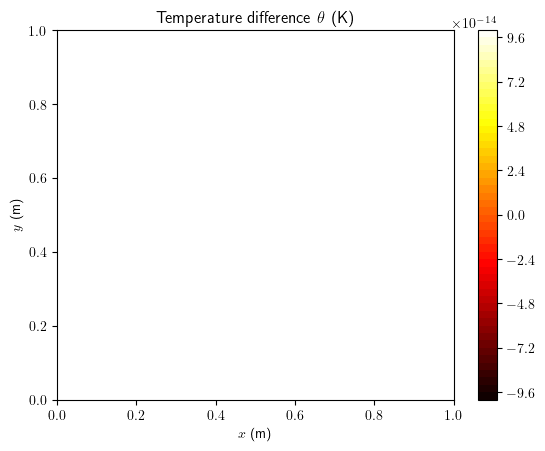

In [234]:
## Plot theta
plot_pot(msh, theta, nz=2, levels=n, cmap='hot', title=r'Temperature difference $\theta$ (K)')